## Necessary Module Importation

REGRESSION ANALYSIS-BUILDING MODELS TO PREDICT STORE SALE USING TIME SERIES FORECASTING

INTRODUCTION

Time series forecasting entails making scientific predictions by analyzing historical data with timestamps. The process involves constructing models through a thorough examination of past data and utilizing them to make informed observations, guiding future strategic decision-making. It's crucial to note that during the forecasting process, the future outcome is entirely unknown and can only be approximated through meticulous analysis and evidence-based assumptions.

PROJECT OBJECTIVE

The primary goal of this project is to predict product unit sales across various stores, with the intention of enhancing inventory management, refining marketing strategies, and optimizing pricing decisions for Favorita Corporation. To achieve this objective, we have employed a combination of time series analysis and various machine learning algorithms within the CRISP-DM framework.

The aim of this analysis is to identify the most effective prediction model among the diverse machine learning algorithms that have been tested. The chosen model will serve as the recommended solution for Favorita Corporation, providing valuable insights to facilitate informed decisions regarding retail sales, promotional activities, and customer satisfaction.

ANALYTICAL QUESTIONS
1. Is the train dataset complete (has all the required dates)?

In [1]:
#Import libraries needed for data manipulation, cleaning and visualizations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

# Models

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
#import all the necessary libraries need to laod data from microsoft SQL server

import pyodbc    
from dotenv import dotenv_values
import warnings 

warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=y"

In [4]:
connection = pyodbc.connect(connection_string)

In [5]:
query="SELECT * FROM dbo.oil"
query2="SELECT * FROM dbo.holidays_events"
query3= "SELECT * FROM dbo.stores"

oil_data= pd.read_sql(query, connection)
holidays_data= pd.read_sql(query2, connection)
stores_data= pd.read_sql(query3, connection)

LOAD DATA ON ONEDRIVE

In [6]:
sample_submission = pd.read_csv(r'C:\Users\USER\Desktop\projectone\Regression-Analysis--A-Time-Series-project\Datasets\sample_submission.csv')

test = pd.read_csv(r'C:\Users\USER\Desktop\projectone\Regression-Analysis--A-Time-Series-project\Datasets\test.csv')


LOAD DATA FROM AZUBI GITHUB REPOSITORY

In [7]:
train= pd.read_csv(r'C:\Users\USER\Desktop\projectone\Regression-Analysis--A-Time-Series-project\Datasets\train.csv')
transactions= pd.read_csv(r'C:\Users\USER\Desktop\projectone\Regression-Analysis--A-Time-Series-project\Datasets\transactions.csv')

### DATA PREVIEW

In [8]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [10]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [12]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Data Wrangling

In [14]:
holidays_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [15]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [16]:
holidays_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

OBSERVATIONS
1. Holiday dataset has 360 rows and 6 columns
2. The date column is in an object format 
3. There are no missing values in the dataset

In [17]:
oil_data

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [18]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [19]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

OBSERVATIONS
1. The oil dataset contains 1218 rows and 2 columns
2. it also contains 43 null values
3. There are no duplicates in the dataset
4. The date column is in a object format and needs to be changed to a datetime format

In [20]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [21]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

OBSERVATIONS
1. The are no null values in the dataset
2. The date column appears in an object format

In [22]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [23]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [24]:
stores_data.duplicated().sum()

0

OBSERVATIONS
1. All attributes are in their right format 
2. There are not duplicates in the datasets

In [25]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Date column is in 'Object' format

### Data Visualization

#### Univariate Analysis

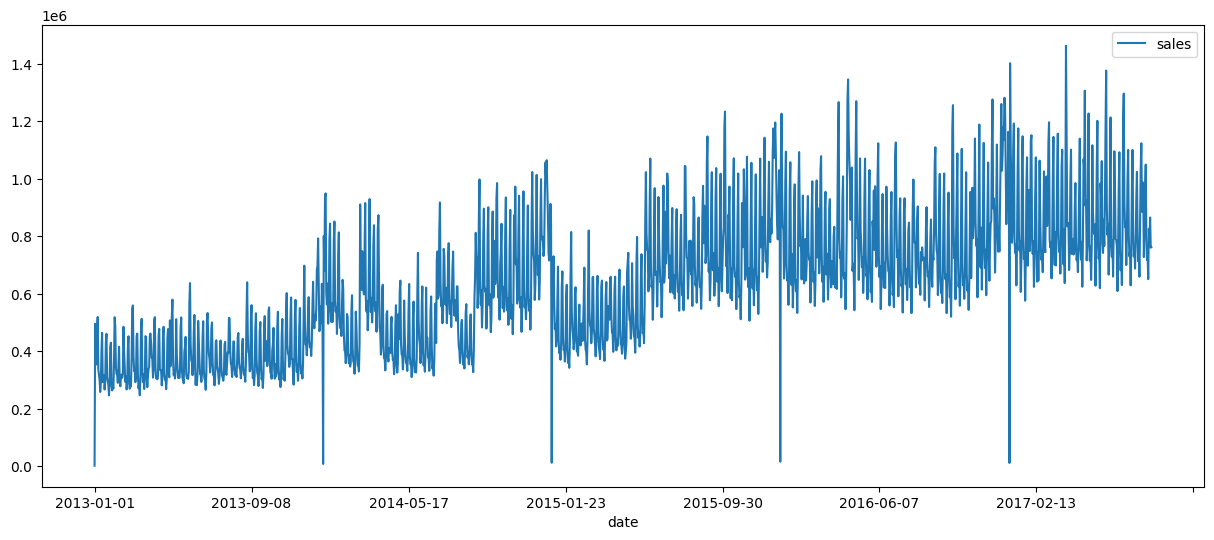

In [26]:
sales_trend = train.groupby('date').sales.sum().reset_index()    
sales_trend = sales_trend.set_index('date')

sales_trend.plot(figsize=(15, 6))
plt.show()

 The train data appears to be in a upward trend however it is worthy to note that sales declined sharply at the beginning of each year.

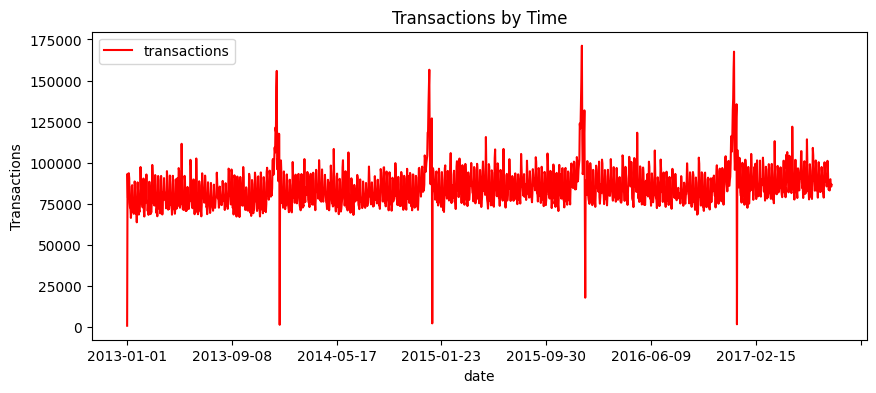

In [27]:
transaction_trends = transactions.groupby('date').transactions.sum().reset_index()
transaction_trends = transaction_trends.set_index('date')

transaction_trends.plot(figsize = (10,4), color= ('red'))
plt.title('Transactions by Time')
plt.ylabel('Transactions')
plt.show()

A clear observation reveals a consistent rise in yearly transactions towards the right, with 2016 standing out as the year with the highest sales records. However, the month-to-month records indicate relatively stable transaction levels over the recorded years. The only exceptions are the year-end periods, where sharp increases in transactions occur, indicating a seasonal pattern.

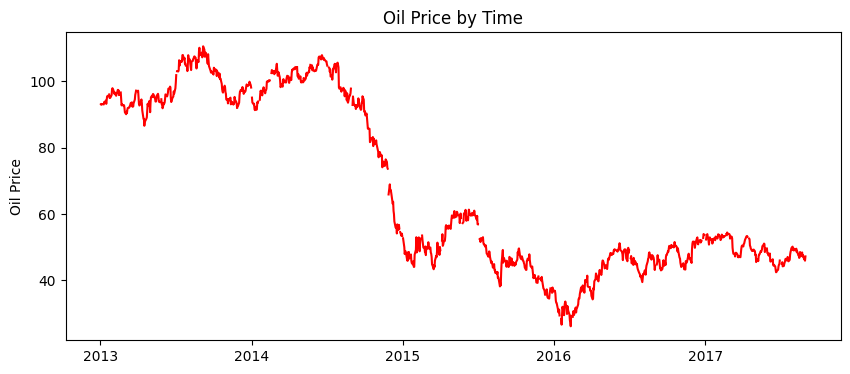

In [28]:
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_price_overtime = oil_data.groupby('date')['dcoilwtico'].mean().reset_index()
oil_price_by_time = oil_price_overtime.set_index('date')

plt.figure(figsize=(10, 4))
plt.plot(oil_price_by_time.index, oil_price_by_time['dcoilwtico'], color='red')
plt.title('Oil Price by Time')
plt.ylabel('Oil Price')
plt.show()

The trend indicates a decrease in oil prices from 2015. Additionally, a noticeable disruption in the trend is attributed to the presence of missing or NaN values.

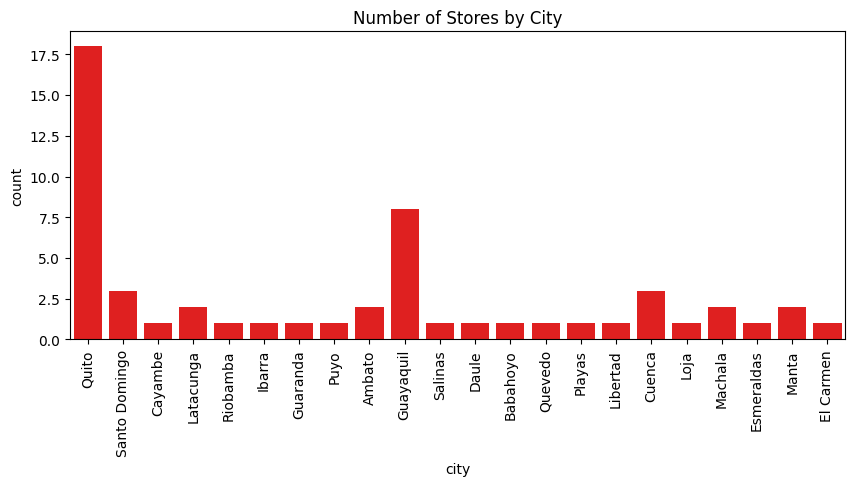

In [29]:
stores_data.set_index('store_nbr', inplace=True)
plt.figure(figsize=(10, 4))
sns.countplot(data=stores_data, x='city', color= 'red')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

The visual representation indicates that Quito and Guayaquil boast the highest store counts, while other cities maintain an average of one store per city.

#### Holidays investigation

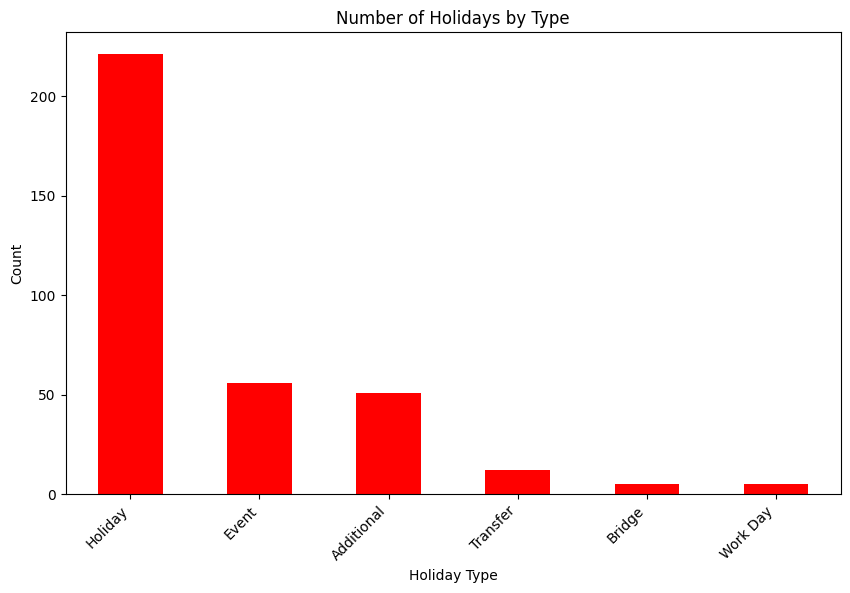

In [30]:
holiday_counts = holidays_data['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar', color='red')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


Converting the date columns to date format

In [31]:
train['date'] = pd.to_datetime(train['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
test['date'] = pd.to_datetime(test['date'])



#### Hypothesis & Questions

1. Is the train dataset complete (has all the required dates)?

In [32]:

expected_dates = pd.date_range(start=train['date'].min(), end=train['date'].max(), freq='D')
missing_dates = expected_dates[~expected_dates.isin(train['date'])]

if missing_dates.empty:
    print("The train dataset is complete.")
else:
    print("The train dataset is missing dates:")
    for date in missing_dates:
        print(date)


The train dataset is missing dates:
2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


The missing dates in the train dataset, specifically on December 25th for the years 2013, 2014, 2015, and 2016, suggest that there might be no data recorded for those particular dates. This could be attributed to the observance of the Christmas holiday by the organization, resulting in the absence of sales transactions or relevant information collection during that period. This conclusion is drawn from further investigations, considering that the Christmas holiday falls on different days in these respective years: 2013-12-25 (Wednesday), 2014-12-25 (Thursday), 2015-12-25 (Friday), and 2016-12-25 (Sunday).

2. Dates with highest and lowest Sales

Dates with the lowest sales for each year:
         year       date  sales
0        2013 2013-01-01    0.0
648648   2014 2014-01-01    0.0
1297296  2015 2015-01-01    0.0
1945944  2016 2016-01-01    0.0
2596374  2017 2017-01-01    0.0

Dates with the highest sales for each year:
         year       date       sales
562596   2013 2013-11-12   46271.000
1257246  2014 2014-12-08   45361.000
1916586  2015 2015-12-14   40351.460
2163723  2016 2016-05-02  124717.000
2760297  2017 2017-04-02   38422.625


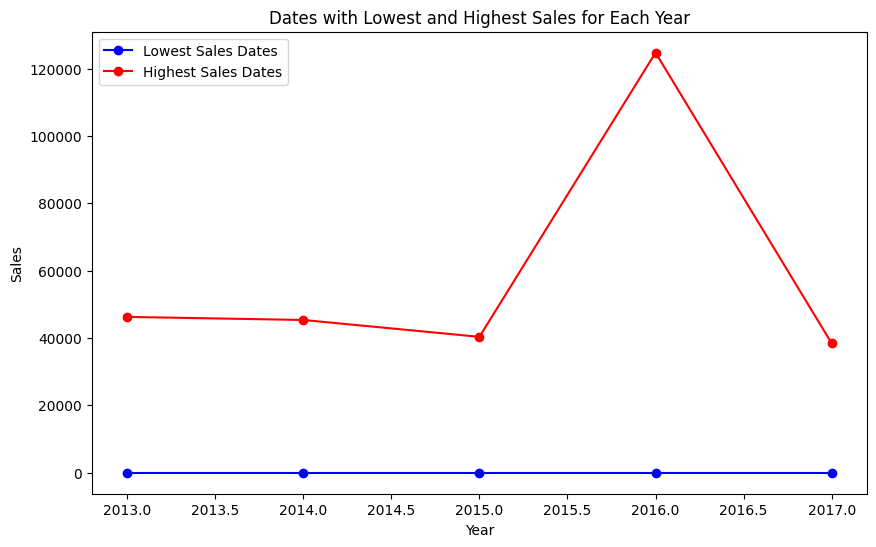

In [33]:
#train['date'] = pd.to_datetime(train_data['date'])
train['year'] = train['date'].dt.year
lowest_sales_dates = train.loc[train.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
highest_sales_dates = train.loc[train.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates)
print("\nDates with the highest sales for each year:")
print(highest_sales_dates)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lowest_sales_dates['year'], lowest_sales_dates['sales'], color='blue', label='Lowest Sales Dates', marker='o')
ax.plot(highest_sales_dates['year'], highest_sales_dates['sales'], color='red', label='Highest Sales Dates', marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Dates with Lowest and Highest Sales for Each Year')
ax.legend()
plt.show()

3. Impact of April 16, 2016 earthquake on sales.

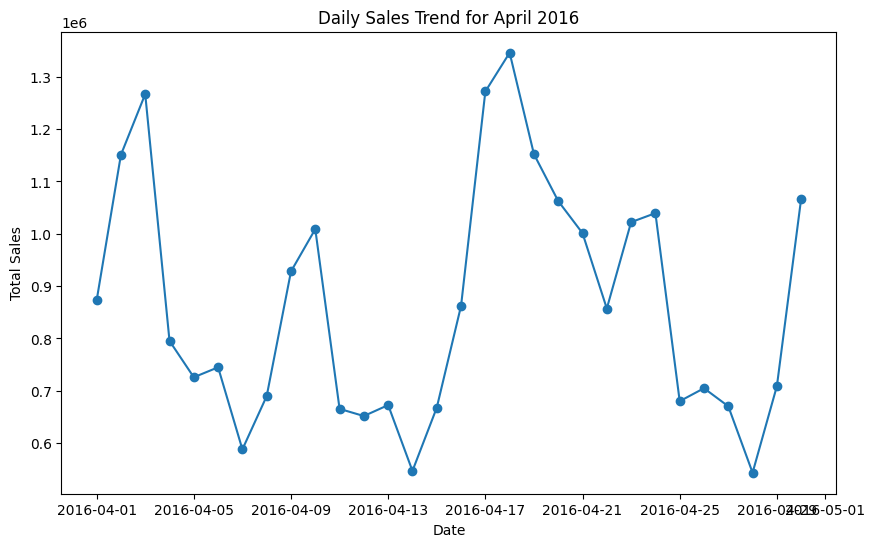

In [34]:
#filter out all the sales that occurred in April 2016
april_2016= train[(train['date']>='2016-04-1')& (train['date']<='2016-04-30')]
#april_2016
#group data by date and the sum of daily sales for April
sales_trend= april_2016.groupby(['date'])['sales'].sum()

plt.figure(figsize=(10, 6))
plt.plot(sales_trend.index, sales_trend.values, marker='o', linestyle='-')
plt.title('Daily Sales Trend for April 2016')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.show()

The earthquake did not appear to have a noticeable effect on sales. The chart above illustrates a consistent upward trend in sales from April 16th, 2016, to April 22nd, 2016. Despite the occurrence of the earthquake on April 16th, 2016, sales continued to follow a consistent pattern.

4 TOP FIVE  STORES WITH THE MOST TRANSACTIONS

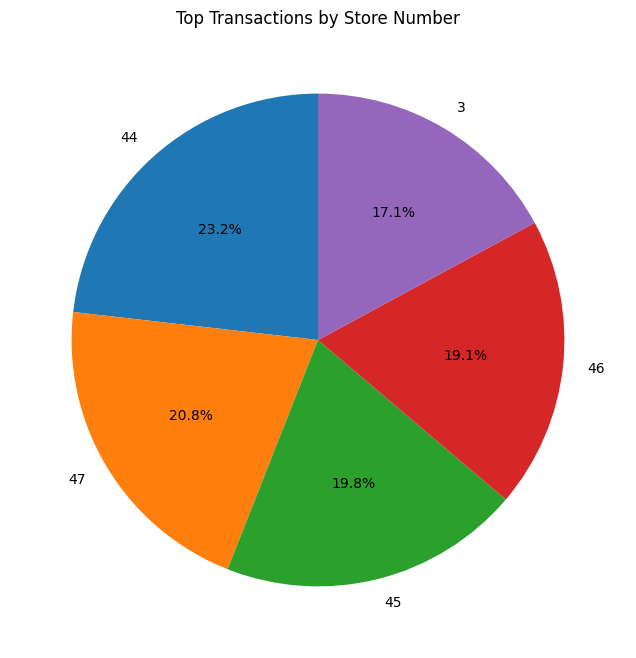

In [35]:
top_transactions= transactions.groupby('store_nbr')['transactions'].sum().sort_values(ascending=False).head()

top_transactions.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.title('Top Transactions by Store Number')
plt.ylabel('') 
plt.show()

Store 44 has the highest transactions by a margin of 23.2%

5. WHICH CITY HAS THE HIGHEST STORES?

Text(0.5, 1.0, 'Number of store by cities')

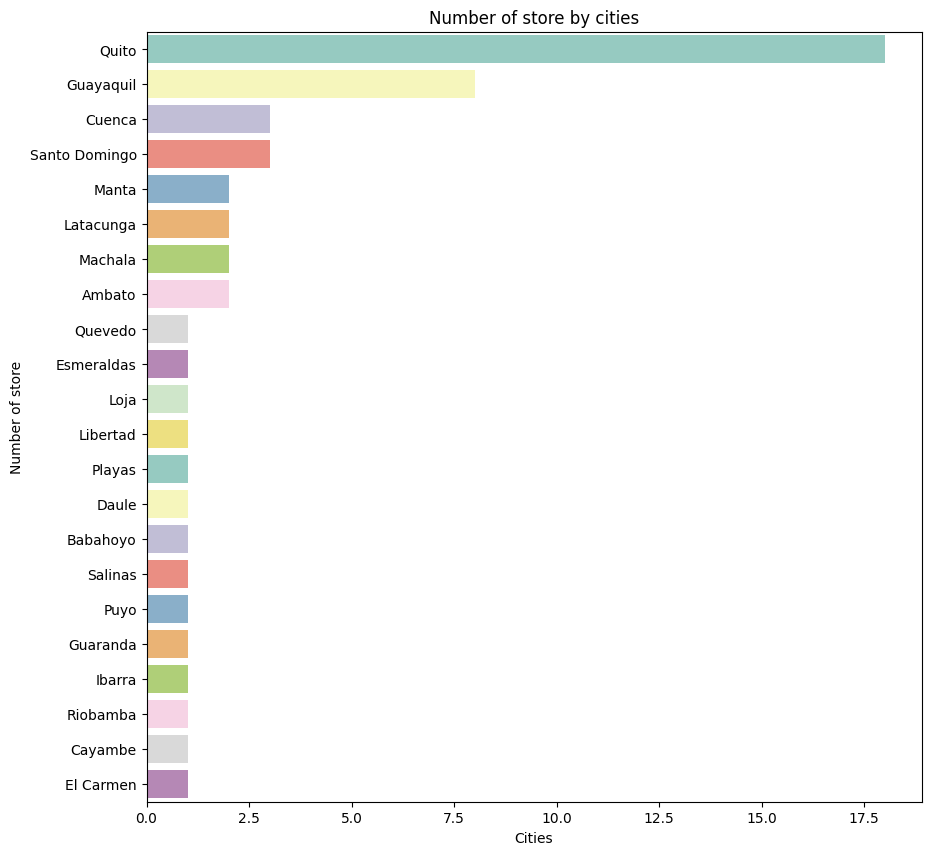

In [36]:
stores_by_cities= stores_data['city'].value_counts()
plt.figure(figsize=(10,10))
colors = sns.color_palette('Set3', n_colors=len(stores_by_cities))
sns.barplot(x=stores_by_cities, y=stores_by_cities.index, palette=colors)
plt.xlabel('Cities')
plt.ylabel('Number of store')
plt.title('Number of store by cities')

From our visuals, Quito has the highest number of stores 

RESET INDEX TO DATE COLUMN

In [37]:
train.set_index('date', inplace= True)

STATIONARITY  TEST (KPSS TEST)
A stationarity test in time series analysis is performed to check whether a given data is stationary or not. For this project, i will use Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test to test for stationarity.

In [38]:
stats,p,lags,critical_values = kpss(train['sales'],'ct')

print(f"Stats: {stats}\n")
print(f"P-Value: {p}\n")
print(f"Lags: {lags}\n")
print(f"Critical Values: {critical_values}\n")

if p< 0.05:
    print('The data is not stationary')
else:
    print('The dataset is stationary')

Stats: 1.1088612328908587

P-Value: 0.01

Lags: 647

Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

The data is not stationary


DATA DIFFENCING


In [39]:
sales_data = train['sales']

# Apply a logarithmic transformation (natural logarithm)
log_sales_data = np.log1p(sales_data)  # Using np.log1p to handle zero values safely

# Replace the 'sales' column with the transformed data in the DataFrame
train['sales'] = log_sales_data

# Perform first-order differencing
first_order_diff = train['sales'].diff(periods=1).dropna()

# Perform KPSS test on the differenced data
kpss_result = sm.tsa.kpss(first_order_diff)

# Extract KPSS test results for differenced data
kpss_statistic, p_value, lags, critical_values = kpss_result

# Print results
print(f'KPSS Statistic (Differenced Data): {kpss_statistic}')
print(f'p-value (Differenced Data): {p_value}')
print(f'Number of Lags Used (Differenced Data): {lags}')
print(f'Critical Values (Differenced Data): {critical_values}')

# Check if the differenced data is stationary
if p_value > 0.05:
    print('The differenced data is stationary. You can proceed with modeling.')
else:
    print('The differenced data is not stationary.')

KPSS Statistic (Differenced Data): 0.00010866464837815819
p-value (Differenced Data): 0.1
Number of Lags Used (Differenced Data): 411
Critical Values (Differenced Data): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The differenced data is stationary. You can proceed with modeling.


### Feature Engineering and Modelling

In [40]:
#split data into x and y

x= train.drop(['sales','id'], axis=1)

y= train['sales']



LABEL ENCODED

In [41]:
label_encoder = LabelEncoder()

# Iterate through each column in the x dataset
for column in x.columns:
    # Check if the column data type is object (categorical) or bool
    if x[column].dtype == 'object':
        # Fit and transform the label encoder on the combined data
        x[column] = label_encoder.fit_transform(x[column])

In [42]:
X_train, X_eval, Y_train, Y_eval= train_test_split(x,y, test_size= 0.2, random_state= 42, shuffle= False)
 

In [43]:
# Define preprocessing steps for numerical and categorical features
numerical_features = x.select_dtypes(include='number').columns
categorical_features = x.select_dtypes(include='object').columns

In [44]:
# CREATE A PIPELINE FOR NUMERICAL AND CATEGORICAL DATA


numerical_data= Pipeline(steps=[
    ('num_imputer',SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    
])


categorical_data= Pipeline(steps=[
    ('cat_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore')),
    
    
])

Preprocessor= ColumnTransformer([
    ('numerical',numerical_data,numerical_features ),
    ('categorical',categorical_data,categorical_features)
])

XGBOOST MODEL

In [45]:
xgboost_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('Xgboost_model', XGBRegressor())
])

xgboost_model.fit(X_train,Y_train)

xgboost_forecast = xgboost_model.predict(X_eval)

In [46]:
Y_eval = np.clip(Y_eval, a_min=0, a_max=None)
xgboost_forecast = np.clip(xgboost_forecast, a_min=0, a_max=None)

 #Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval,  xgboost_forecast)


# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval,  xgboost_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.5160461986314435
Mean Squared Logarithmic Error (MSLE): 0.07475420679535093
Root Mean Squared Error (RMSE): 0.718363556029566
Root Mean Squared Logarithmic Error (RMSLE): 0.27341215553693093


The evaluation metrics for the XGBoost model indicate good performance. The model seems to be making accurate predictions with relatively small errors on average. The basis for the conclusion is that the model's predictions are, on average, close to the actual values, as indicated by low values of MSE, MSLE, and MAE. The moderate RMSE and RMSLE values suggest that, while there are errors, they are not excessively large.

2. LINEAR REGRESSION MODEL

In [47]:
linear_reg_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('Linear_model', LinearRegression())
])

linear_reg_model.fit(X_train,Y_train)

linear_reg_forecast = linear_reg_model.predict(X_eval)

EVALUATE MODEL

In [48]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, linear_reg_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, linear_reg_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 4.980527857489623
Mean Squared Logarithmic Error (MSLE): 0.5100912984520832
Root Mean Squared Error (RMSE): 2.2317096266068357
Root Mean Squared Logarithmic Error (RMSLE): 0.7142067616958574


The root mean squared logarithic error for the model scored 0.71. This is an indicating that the model is not performoing well. we will explore other models to find a better option

3. DESCISION TREE MODEL

In [49]:

# Descision tree model
descision_tree = Pipeline([
    ('preprocessor', Preprocessor),
    ('descision_tree', DecisionTreeRegressor(random_state=42))
])

descision_tree.fit(X_train,Y_train)

descision_tree_forecast = descision_tree.predict(X_eval)

EVALUATE MODEL

In [50]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, descision_tree_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, descision_tree_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.42856373459351993
Mean Squared Logarithmic Error (MSLE): 0.06371881436221703
Root Mean Squared Error (RMSE): 0.6546477943089092
Root Mean Squared Logarithmic Error (RMSLE): 0.25242585913930654


The decision tree regressor performed relatively better will an RMSLE score of 0.25

4. RANDOM FOREST MODEL

In [51]:
#from sklearn.ensemble import GradientBoostingRegressor
Random_forest_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('descision_tree', RandomForestRegressor())
])

Random_forest_model.fit(X_train,Y_train)


Random_forest_model_forecast = Random_forest_model.predict(X_eval)

EVALUATE MODEL

In [52]:
#Y_eval = np.clip(Y_eval, a_min=0, a_max=None)
#Gradient_model_forecast = np.clip(Gradient_model_forecast, a_min=0, a_max=None)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, 
Random_forest_model_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, Random_forest_model_forecast)


# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.420057257659768
Mean Squared Logarithmic Error (MSLE): 0.06335942661280737
Root Mean Squared Error (RMSE): 0.6481182435788766
Root Mean Squared Logarithmic Error (RMSLE): 0.2517129845931818


The random forest regressor also performed relatively better, having the same RMSLE score as the descision tree regressor

Based on the results, the models that performed well the the decision tree and Random forest models with an RMSLE score of 0.25

RECOMMENDATIONS


SENIOR MANAGEMENT: Based on the findings, we suggests that, management employ a Decision Tree Regressor for predicting retail sales, considering its ability to capture both seasonal patterns and trends in time series data. Furthermore, enhancing data quality by addressing outliers and missing values is crucial to enhance the accuracy of the model.


MARKETING TEAM: 
The marketing team can employ the Decision Tree Regressor for predicting the influence of promotions on retail sales. Analyzing the effects of past promotions on sales allows the marketing department to fine-tune its promotional approach and enhance overall sales outcomes. Additionally, the model proves valuable in forecasting sales for new products and evaluating the potential impact of launching new items on overall sales performance.